# GridSearch com Pipeline apenas com dados dos canais selecionados

Explorando busca em grade para determinar melhor parâmetro `C` do classificador apenas com os melhores canais já selecionados previamente.

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd

from seaborn import scatterplot
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, GroupKFold

# Carregando intervalo de chb
file_range = [
    '01', '02', '03', '04', '05', '07', '08',
    '10', '11', '12', '13', '14', '15', '16',
    '17', '18', '19', '21', '22', '23', '24'
]

def dataframe_from_chb(chb_number:str) -> pd.DataFrame:
    df = pd.read_csv(f'./chb{chb_number}/chb{chb_number}_com_dwt.csv')
    df['chb'] = chb_number
    return df

In [2]:
chb_df = pd.concat([dataframe_from_chb(file) for file in file_range], ignore_index=True)

some_6_channels = ['2', '3', '6', '7', '10', '14']

# Filtrando colunas do chb que são referentes aos canais em some_6_channels
columns_from_6_channels = [column for column in chb_df.columns if column.split('-')[-1] in some_6_channels]

chb_groups = chb_df.pop('chb').values
chb_y = chb_df.pop('target').values
chb_X = chb_df[columns_from_6_channels].values

pipe = make_pipeline(StandardScaler(), SVC(cache_size=500))

folds = GroupKFold(n_splits=len(np.unique(chb_groups))).split(chb_X, chb_y, chb_groups)

C_grid = {'svc__C':np.linspace(0, 2, 9)[1:]}

In [3]:
gs = GridSearchCV(
    estimator=pipe,
    param_grid=C_grid,
    cv=folds
).fit(
    X=chb_X,
    y=chb_y,
    groups=chb_groups
)

pd.DataFrame(gs.cv_results_).to_csv('./09-pipe-gs-svc-oneVSall_with_some_6channels.csv', index=False)

In [4]:
columns = ['rank_test_score', 'param_svc__C', 'mean_test_score', 'std_test_score']

cv_results_df = pd.read_csv('./09-pipe-gs-svc-oneVSall_with_some_6channels.csv')[columns]

cv_results_df.style.background_gradient(cmap='Blues', subset=['mean_test_score']).hide_index()

rank_test_score,param_svc__C,mean_test_score,std_test_score
1,0.250000,0.812465,0.177642
2,0.500000,0.810229,0.179620
3,0.750000,0.807811,0.177593
4,1.000000,0.806454,0.177619
5,1.250000,0.805688,0.178423
6,1.500000,0.804752,0.180889
7,1.750000,0.804130,0.182248
8,2.000000,0.802675,0.181968


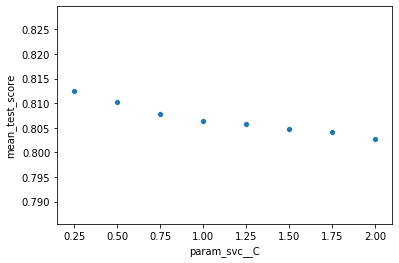

In [5]:
scatterplot(
    data=cv_results_df,
    x='param_svc__C',
    y='mean_test_score'
)